# Predicting Heart Disease Onset
In this project, I aim to predict whether a patient will develop heart disease using a K-nearest neighbour algorithm trained on a dataset of anonymized data from multiple hospitals on several patients


In [1]:
# Importing the libraries I will need
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [2]:
# Importing the dataset as a pandas DataFrame
heart_disease = pd.read_csv('Datasets/heart.csv')

In [3]:
# Investigating the first few rows of the DataFrame
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Displaying the number of features observations
print(f"Number of features: {heart_disease.shape[1] - 1}")
print(f"Number of observations: {heart_disease.shape[1] - (heart_disease.shape[1] - 1)}")

Number of features: 11
Number of observations: 1


In [5]:
# Listing the dtypes of each column to determine which columns are categorical and numerical
heart_disease.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [6]:
# Grouping the columns of the dataset into categorical and numerical lists. 
numerical_columns = []
categorical_columns = []
for column in heart_disease.columns:
    if heart_disease[column].dtype == 'int64':
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)
        
# I then move the 'FastingBS' and 'HeartDisease' columns to the categorical lists, 
# despite their datatypes being int64, as they only take the values 0 and 1

value_to_move = numerical_columns.pop(3)
categorical_columns.append(value_to_move) # moving the 'FastingBS' column name

value_to_move = numerical_columns.pop(-1)
categorical_columns.append(value_to_move) # moving the 'HeartDisease' column name

In [7]:
# Checking that the intended column names have been moved
print(f"numerical columns: {numerical_columns}")
print(f"categorical_columns: {categorical_columns}")      

numerical columns: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
categorical_columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'FastingBS', 'HeartDisease']


In [8]:
# Now I want to take a look at the descriptive statistics from this dataset
heart_disease.describe().round(2)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


We can see that the average age for a patient in this dataset is 54 years. One statistic that stands out are the values of 0.00 as minimum values in the Resting Blood Pressure and Cholesterol columns as it wouldn't be possible for a patient to have a blood pressure of 0 mm Hg. A cholesterol level of 0 mm/dl indicated the patient may have a rate genetic disease called Tangier Disease which results in deficiency or absence of high-density lipoprotein in the blood, although this is very unlikely. 

We can also see that there are no missing values in the dataset.

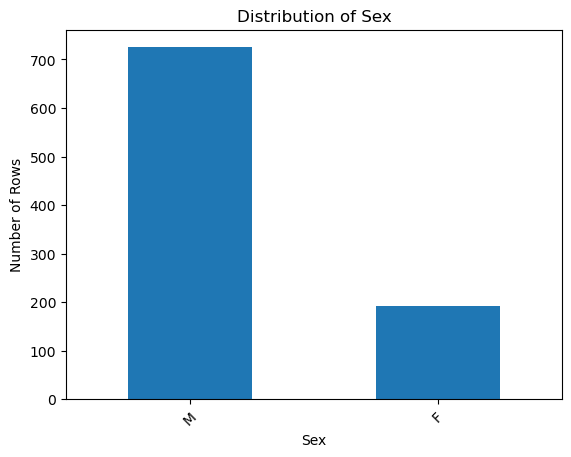

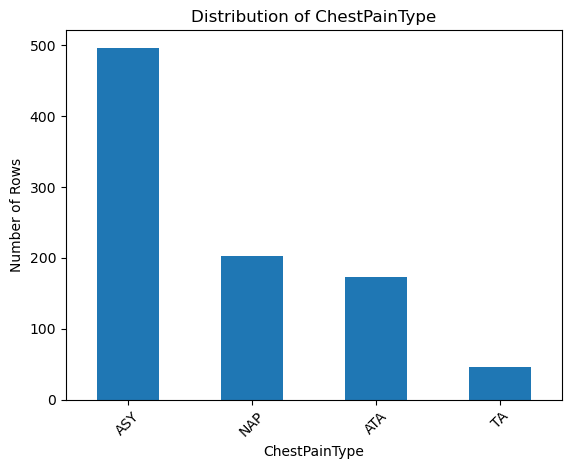

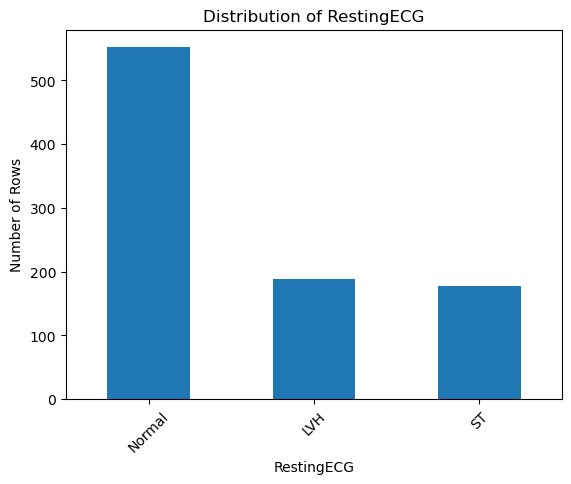

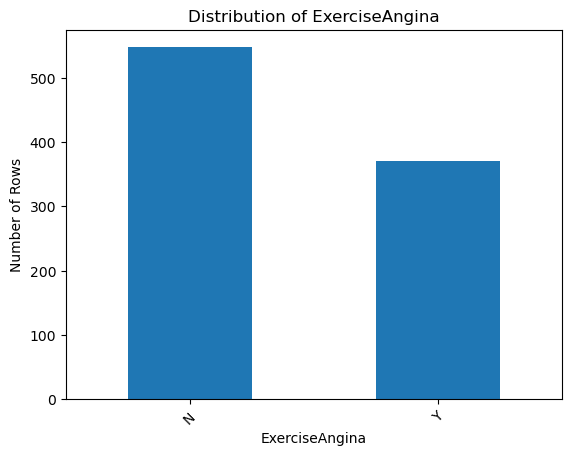

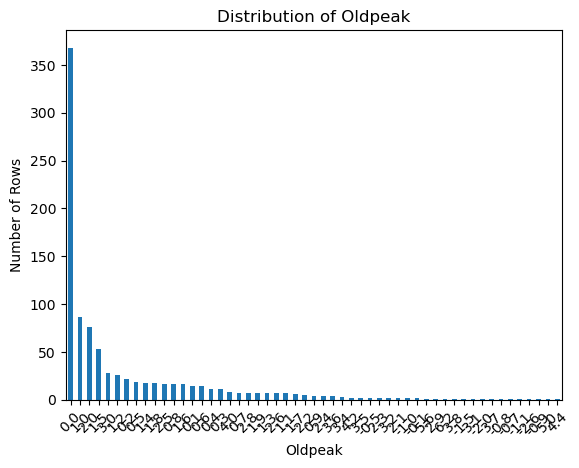

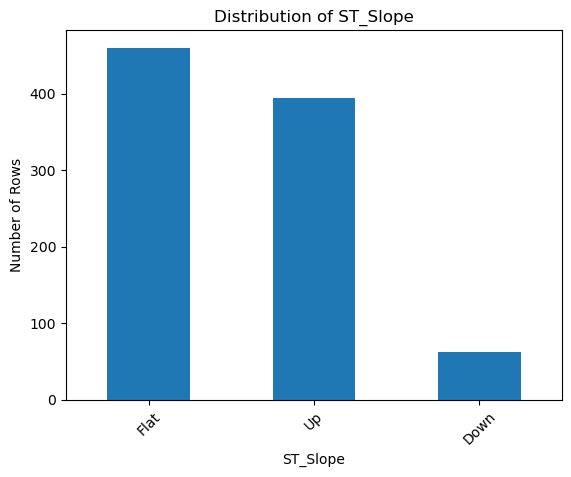

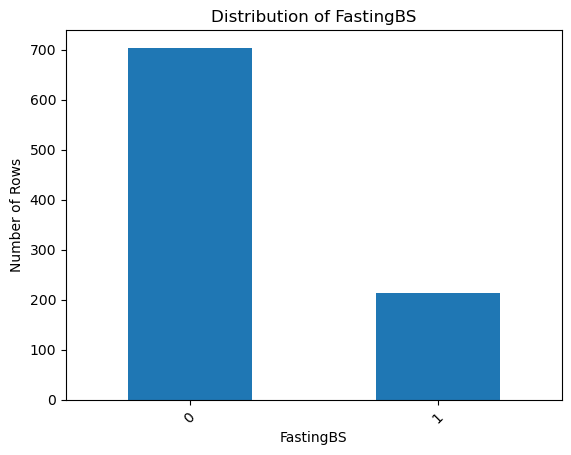

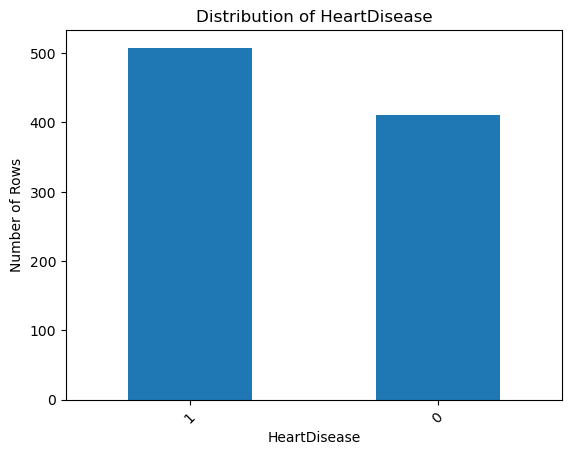

In [9]:
# I'm going to explore each categorical column a bit more to see how the data is distributed
import matplotlib.pyplot as plt
for column in categorical_columns:
    category_counts = heart_disease[column].value_counts()
    
    category_counts.plot(kind='bar') # Create a bar chart
    
    plt.title(f"Distribution of {column}") # Format bar charts
    plt.xlabel(column)
    plt.ylabel('Number of Rows')
    plt.xticks(rotation=45)
    
    plt.show()
    
    

We can see that the vast majority of our dataset is made up of males. 

Asymptomatic patients in regards to chest pain, resting ECG, and exercise induced angina are most common in our dataset.

Patients with downsloping ST segments are least common in this dataset

The number of patients with heart disease in this dataset is greater than the number of healthy patients, however the difference between the two is not too big.

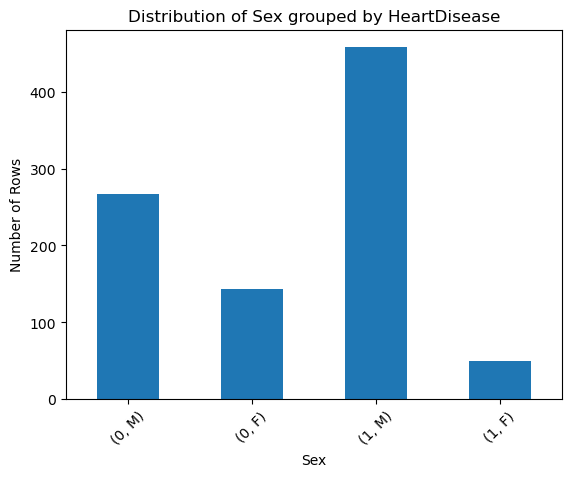

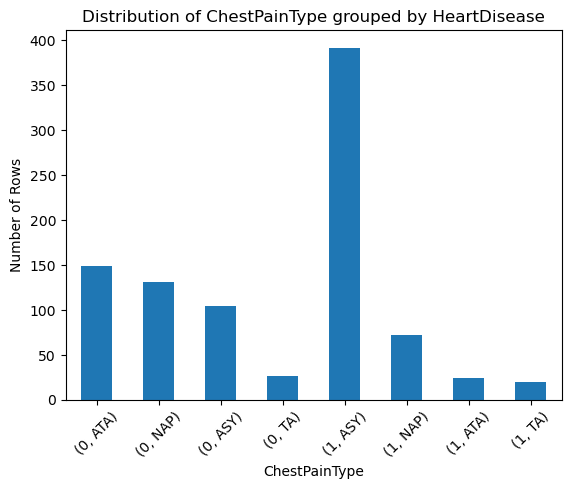

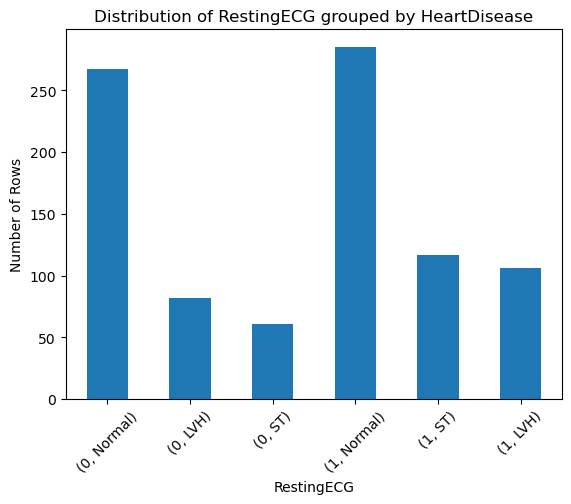

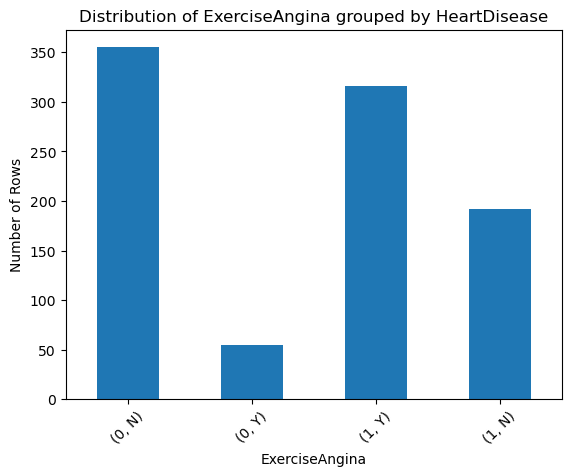

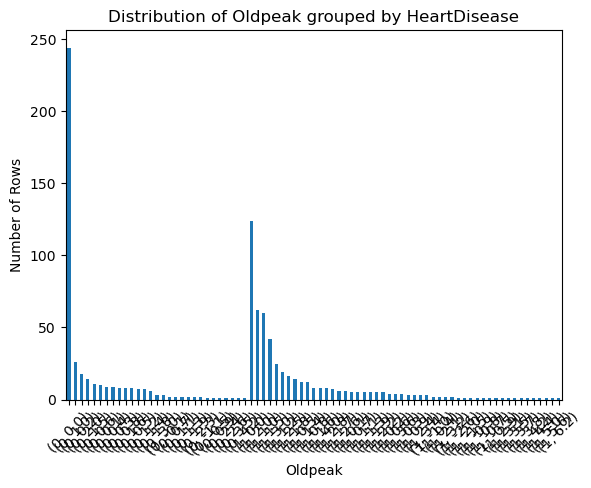

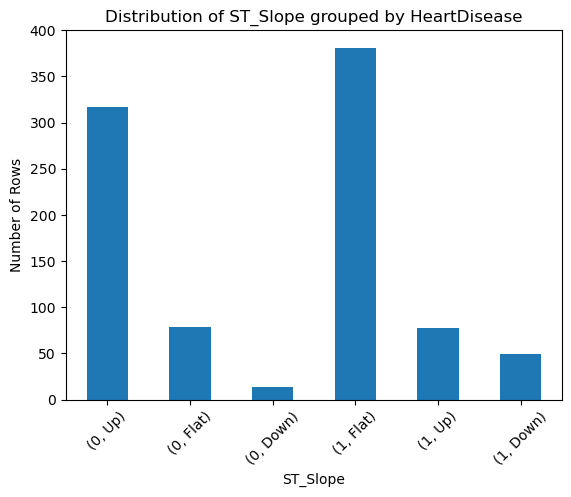

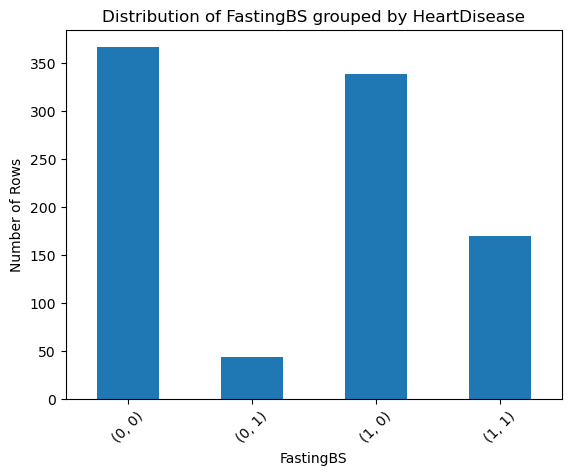

In [10]:
# Now I will explore even further by grouping the data by the observation column

categorical_features = categorical_columns[0:-1]
for column in categorical_features:
    grouped_counts = heart_disease.groupby('HeartDisease')[column].value_counts()
    
    grouped_counts.plot(kind='bar') # Create a bar chart
    
    plt.title(f"Distribution of {column} grouped by HeartDisease") # Format bar charts
    plt.xlabel(column)
    plt.ylabel('Number of Rows')
    plt.xticks(rotation=45)
    
    plt.show()

Some observations from the above bar charts:

Most of the patients with heart disease are men

Most patients with heart disease are asymptomatic in regard to chest pain and resting ECG

Patients without Heart Disease usually did not suffer from exercise induced angina, while patients with Heart Disease usually did

A flat ST slope is more common in those with Heart Disease

In [11]:
# I'll do some data cleaning now to prepare the dataset for training
print(f"Number of rows with a resting BP of 0: {heart_disease['RestingBP'].value_counts()[0]}")
print(f"Number of rows with a cholesterol level of 0: {heart_disease['Cholesterol'].value_counts()[0]}")

Number of rows with a resting BP of 0: 1
Number of rows with a cholesterol level of 0: 172


In [12]:
# Lets find the median of the RestingBP column for those with heart disease and without
heart_disease.groupby('HeartDisease')['RestingBP'].median()

HeartDisease
0    130.0
1    132.0
Name: RestingBP, dtype: float64

In [13]:
# Now lets see if the row with a value of 0 for resting BP is from a patient with or without heart disease
column_of_interest = heart_disease[heart_disease['RestingBP'] == 0]
column_of_interest

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


We see that this row is from a patient with heart disease. Therefore, we will replace the 0 with the median value for the resting BP column for patients with heart disease (132)

In [14]:
median_value = heart_disease.groupby('HeartDisease')['RestingBP'].median()[1]
median_value

132.0

In [15]:

for index, row in heart_disease.iterrows():
    if row['RestingBP'] == 0:
        heart_disease.loc[index, 'RestingBP'] = median_value

In [16]:
column_of_interest = heart_disease.iloc[449]
column_of_interest

Age                   55
Sex                    M
ChestPainType        NAP
RestingBP            132
Cholesterol            0
FastingBS              0
RestingECG        Normal
MaxHR                155
ExerciseAngina         N
Oldpeak              1.5
ST_Slope            Flat
HeartDisease           1
Name: 449, dtype: object

In [17]:
# Lets find the median of the Cholesterol column for those with heart disease and without
heart_disease.groupby('HeartDisease')['Cholesterol'].median()

HeartDisease
0    227.0
1    217.0
Name: Cholesterol, dtype: float64

In [18]:
# Replacing the 0 values for Cholesterol with the median for patients with and without heart disease
for index, row in heart_disease.iterrows():
    if row['HeartDisease'] == 0 and row['Cholesterol'] == 0:
        heart_disease.loc[index, 'Cholesterol'] = heart_disease.groupby('HeartDisease')['Cholesterol'].median()[0]
    if row['HeartDisease'] == 1 and row['Cholesterol'] == 0:
        heart_disease.loc[index, 'Cholesterol'] = heart_disease.groupby('HeartDisease')['Cholesterol'].median()[1]

In [19]:
# lets check that all the 0 values in the cholesterol column are gone:
def check_zero(column):
    if 0 in heart_disease[column].values:
        return True
    else:
        return False

In [20]:
check_zero('Cholesterol')

False

All instances of 0 in the cholesterol column have now been replaced with medians

## Now its time to select our features from our dataset

In [21]:
# Creating dummy columns for each categorical data column
heart_disease = pd.get_dummies(data=heart_disease, columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'], drop_first = True)

In [22]:
heart_disease.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease',
       'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up', 'FastingBS_1'],
      dtype='object')

<AxesSubplot: >

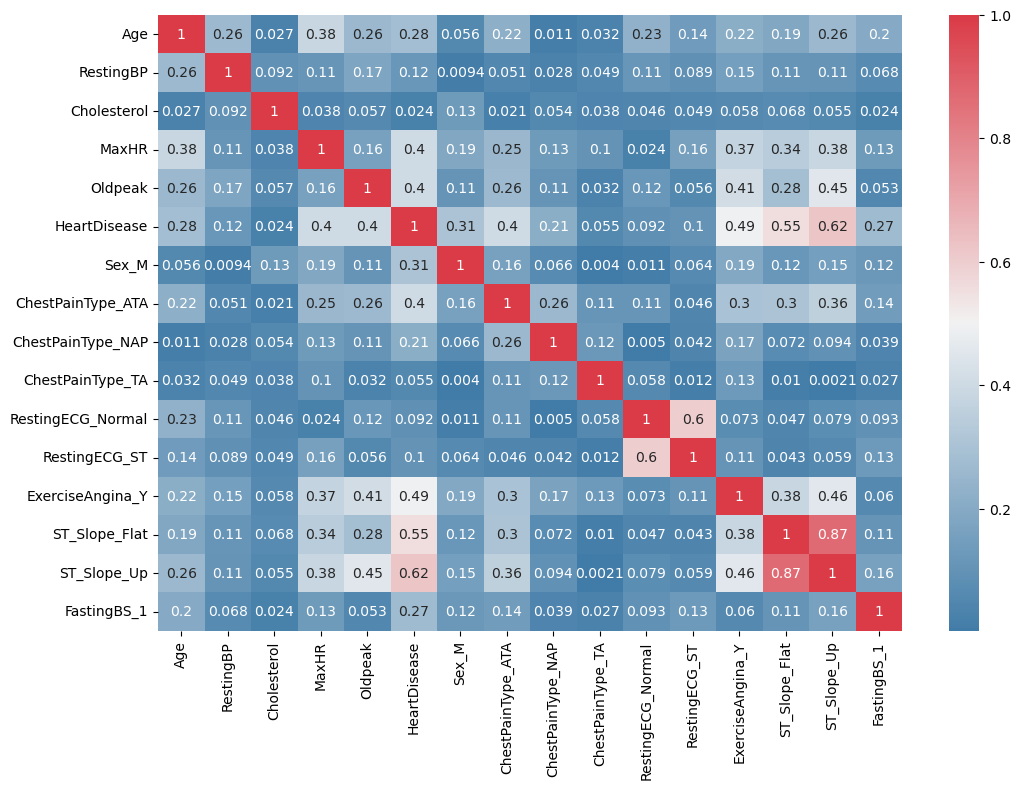

In [23]:
# Looking into which columns are most correlated with the observation column ('HeartDisease')
import seaborn as sns
correlations = abs(heart_disease.corr())
plt.figure(figsize=(12,8))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(correlations, annot=True, cmap=cmap)

<AxesSubplot: >

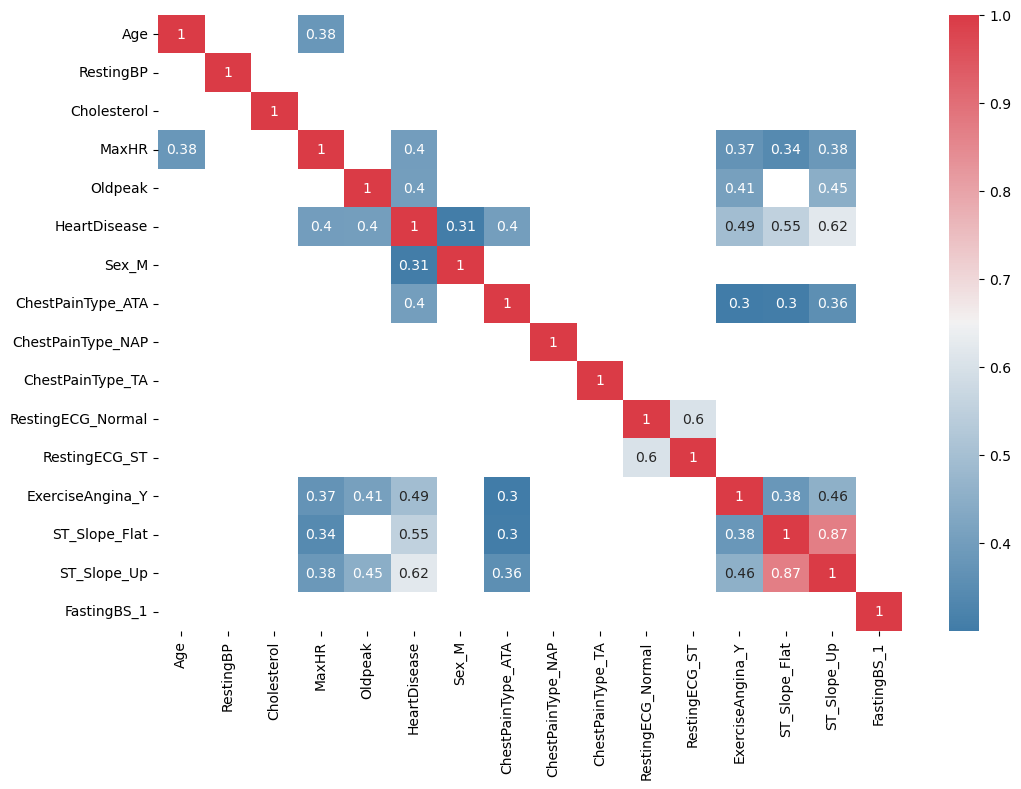

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3],  annot=True, cmap=cmap)

In [25]:
correlations['HeartDisease'].sort_values(ascending = False)[0:6].index

Index(['HeartDisease', 'ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y',
       'Oldpeak', 'ChestPainType_ATA'],
      dtype='object')

We can see that ST_Slope_Up, ST_Slope_Flat, ExerciseAngina_Y, Oldpeak, ChestPainType_ATA are the top 5 features most correlated with HeartDisease. Despite Sex not being in this top 5, I will include this anyway, given what we observed in our EDA.

In [26]:
print(f"Features to be used in the model: \nHeartDisease, ST_Slope_Up, ST_Slope_Flat, ExerciseAngina_Y, Oldpeak, ChestPainType_ATA, Sex_M")

Features to be used in the model: 
HeartDisease, ST_Slope_Up, ST_Slope_Flat, ExerciseAngina_Y, Oldpeak, ChestPainType_ATA, Sex_M


In [27]:
# Now I will split the dataset into a training and validation set
X = heart_disease.drop('HeartDisease', axis=1)
y = heart_disease['HeartDisease']
features = ['ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y',
       'Oldpeak', 'ChestPainType_ATA', 'Sex_M']
#Creating the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X[features], y, test_size = 0.20, random_state = 417)
# Creating the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20*X.shape[0]/X_train.shape[0], random_state = 417)


In [28]:
# Creating a kNN classifier for each of the selected features
for feature in features:
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train[[feature]], y_train)
    y_pred = knn.predict(X_val[[feature]])
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy for a kNN model trained on {feature} with k = 3 is {accuracy*100:.2f}%")


Accuracy for a kNN model trained on ST_Slope_Up with k = 3 is 82.07%
Accuracy for a kNN model trained on ST_Slope_Flat with k = 3 is 79.89%
Accuracy for a kNN model trained on ExerciseAngina_Y with k = 3 is 71.20%
Accuracy for a kNN model trained on Oldpeak with k = 3 is 69.02%
Accuracy for a kNN model trained on ChestPainType_ATA with k = 3 is 66.30%
Accuracy for a kNN model trained on Sex_M with k = 3 is 53.80%


When using just one feature for training, the kNN trained on ST_Slop_Up resulted in the best performance, while the worst performance came from Sex_M

In [29]:
# Before we train a model using all our selected features, lets normalise the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [30]:
# Training the model on all selected features
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 82.07


The accuracy for this model is the same as the model trained on just the ST_Slope_Up feature alone - not great

In [31]:
# Lets experiment with some parameters to see if we can improve the accuracy
grid_params = {'n_neighbors': [1,2,3,4,5], 'weights' : ['uniform','distance'], 'p' : [1,2,3,4,5], 'metric' : ['minkowski']}

knn_2 = KNeighborsClassifier()
gridsearch = GridSearchCV(estimator = knn_2, param_grid = grid_params, scoring = 'accuracy')

gridsearch.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5], 'p': [1, 2, 3, 4, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [32]:
best_score = gridsearch.best_score_
best_params = gridsearch.best_params_

In [33]:
print(best_score)
print("\n")
print(best_params)

0.8418181818181818


{'metric': 'minkowski', 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}


We managed to improve our model! The model has an accuracy of 84% on the training dataset. The best parameters for our model is 'minkowski' for metric, 4 for n_neighbors, 2 for p, and 'uniform' for weights

In [34]:
# Lets scale our test set
X_test_scaled = scaler.transform(X_test[features])

In [35]:
# Scoring the model on our test data
predictions = gridsearch.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 81.52


Our model achieved an accuracy of 81.52% on the test dataset - not bad! The model isn't accurate enough to reliably be used in a healthcare setting, but with more valuable data, this model has potential to have very high accuracy